# DC 4: Networks

Group Members: Eleni Partakki, Elisabeth Nesmith, Lauren Low, Marium Tapal

5th April 2021

## Initial Setup



Initially, our group thought we should use AWS to set up a MySQL database on the cloud. After 6 hours of T/A hours and contacting CATS at Smith, we decided that it was best for our team to take a break from this plan and pursue it for our next challenge as it is a process that taught us a lot about networks, AWS, servers, SQL and debugging.

This is a short breakdown of how our time was used during that time:

*   Made an AWS account
*   Created a MySQL database
* Changed the input and output settings
* Downloaded MySQL Workbench
* Changed databases to PostgreSQL after a suggestion by Ananda
* Could not connect PostgreSQL to the cloud, and after contacting CATS, transferred back to MySQL
* Managed to get the database connected to MySQL Workbench and to R, but then struggled to get the data onto Workbench
* Pivoted due to lack of time

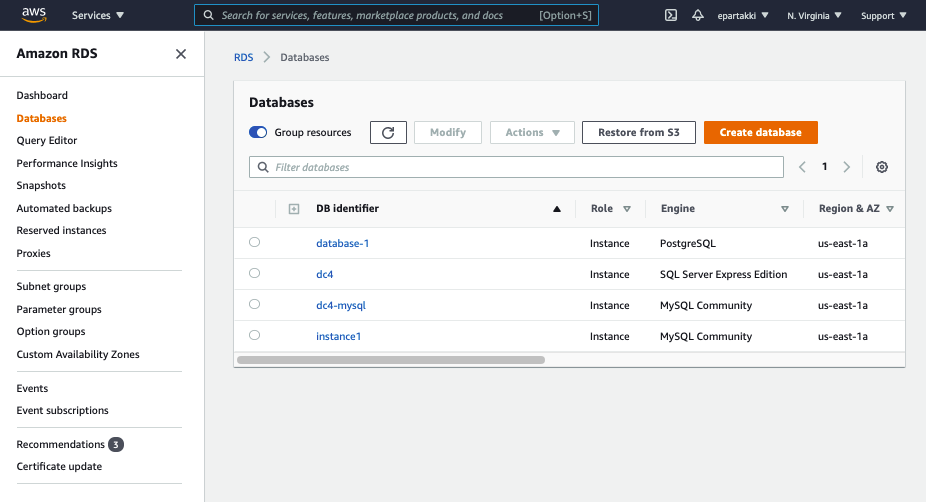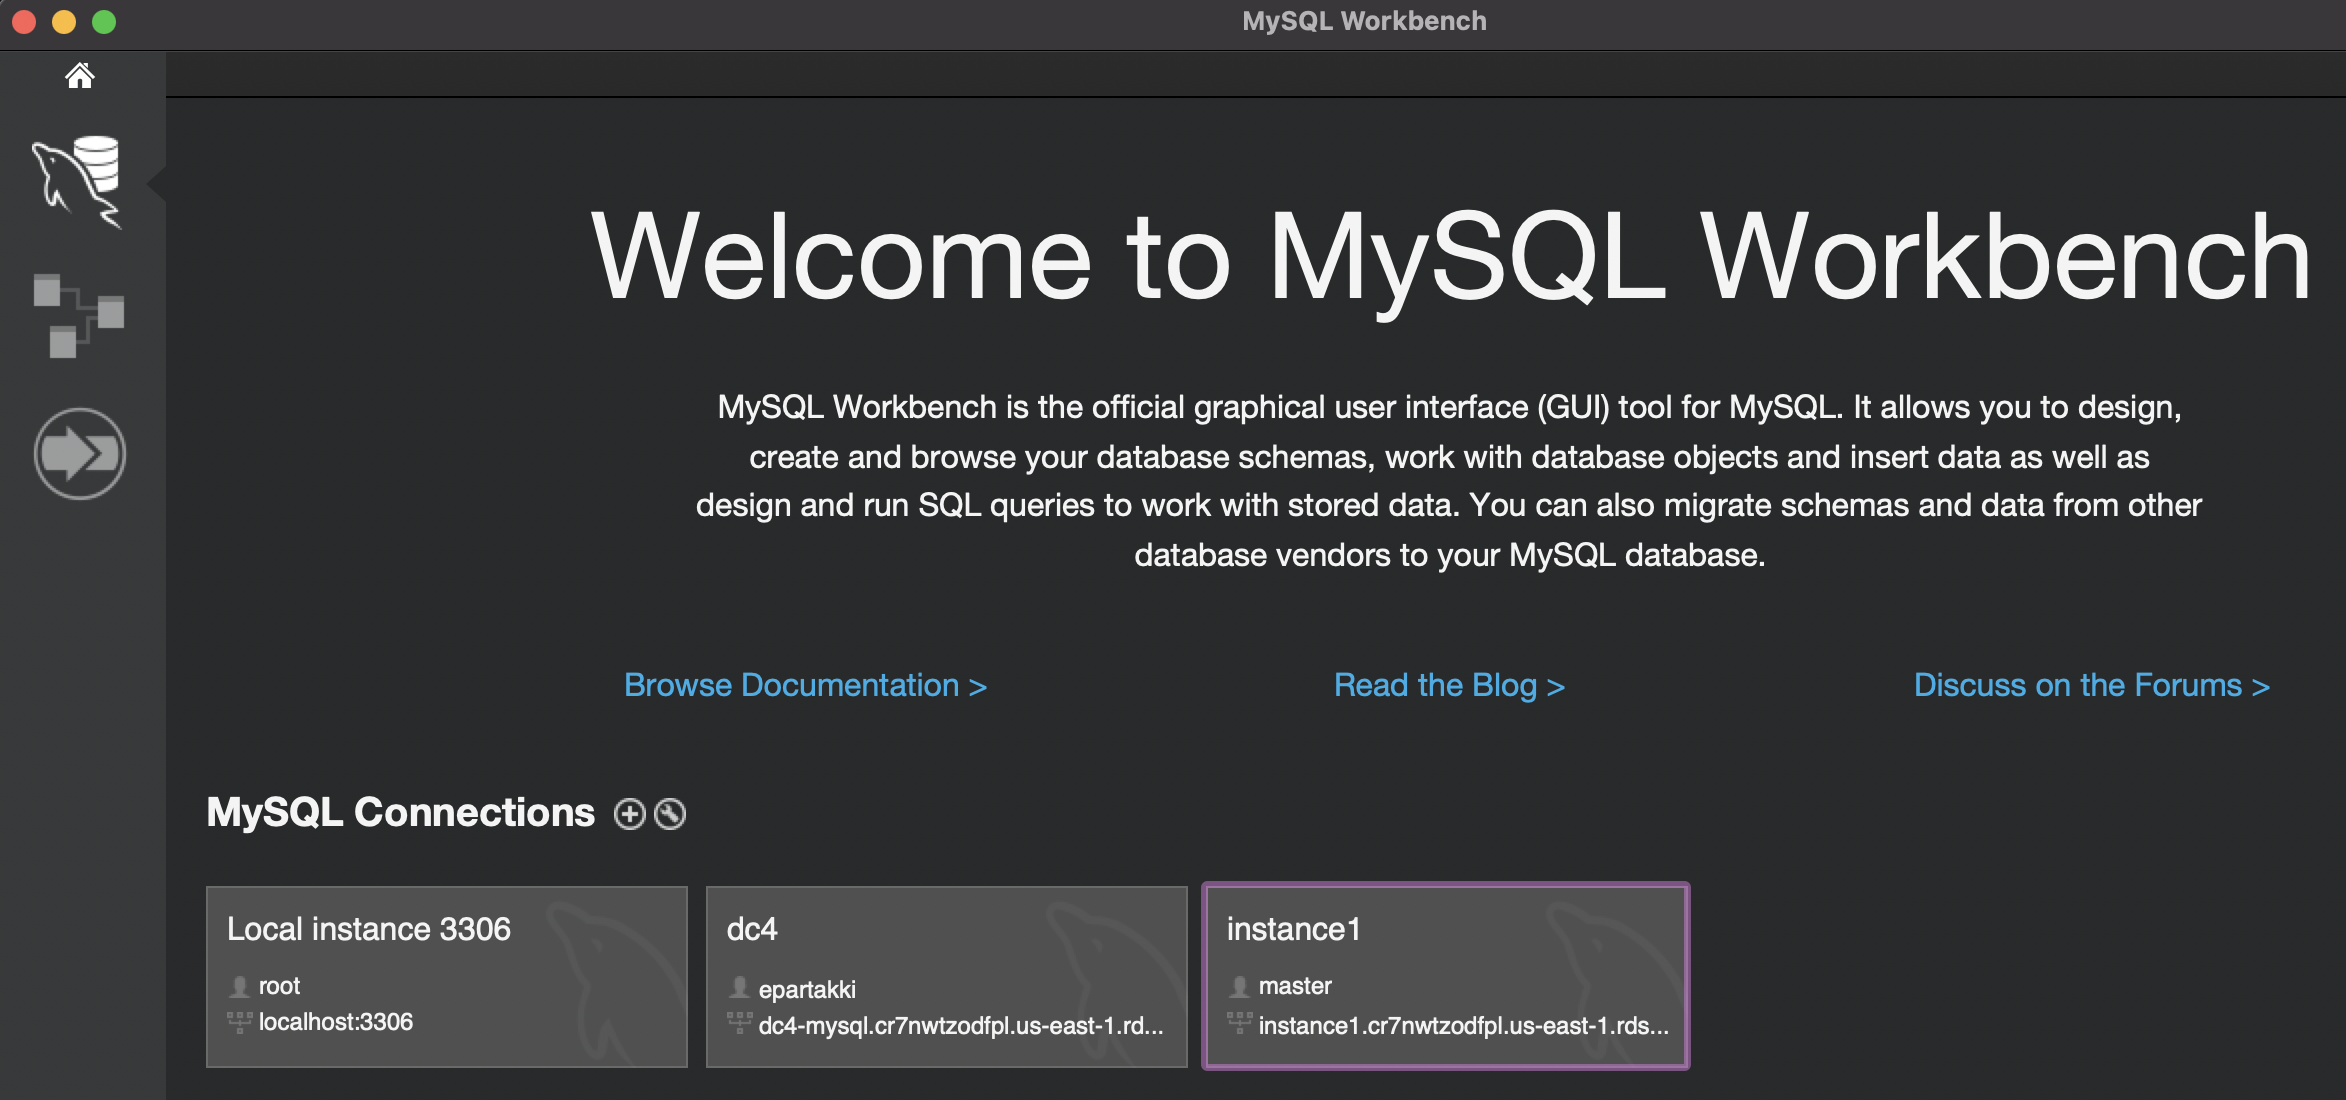



## Setting Up Database (a continuation)

After we successfully set up an instance in AWS and made a connection to MySQL Workbench, we had to actually create a database and a table in order to import the csv. We used the following code in R to do this:

In [ ]:
host="instance1.cr7nwtzodfpl.us-east-1.rds.amazonaws.com"
port= 3306
user="master"
password="password"

my_db = dbConnect(RMySQL::MySQL(),host=host,port=port,user=user,password=password)

dbSendQuery(my_db,"create database database1")

host="instance1.cr7nwtzodfpl.us-east-1.rds.amazonaws.com"
port= 3306
user="master"
password="password"
db = 'database1'

my_db = dbConnect(RMySQL::MySQL(), 
                  host=host,
                  port=port,
                  user=user,
                  password=password,
                  db=db)

dbSendQuery(my_db, "CREATE TABLE ids(
time datetime, 
sourceIP varchar(255), 
sourcePort int, 
destIP varchar(255), 
destPort int, 
classification varchar(255), 
priority int, 
label varchar(255), 
packet_info varchar(255), 
packet_info_cont varchar(255), 
xref varchar(255));"
)

SyntaxError: ignored

However, when trying to actually load the CSV into this data in R, we kept getting an error that the file could not be found. This might have been due to the database not having access to the files on my computer. However, when I tried coding directly in MySQL Workbench, I was able to load one of the CSV's (IDS-0406) to the database using the following code:


In [ ]:
LOAD DATA LOCAL INFILE '~/Desktop/SDS 235 DC4/IDS.csv'
             INTO TABLE ids
             FIELDS TERMINATED by ','
             ENCLOSED BY '\"'
             LINES TERMINATED BY '\r\n';

The resulting dataset looked like this: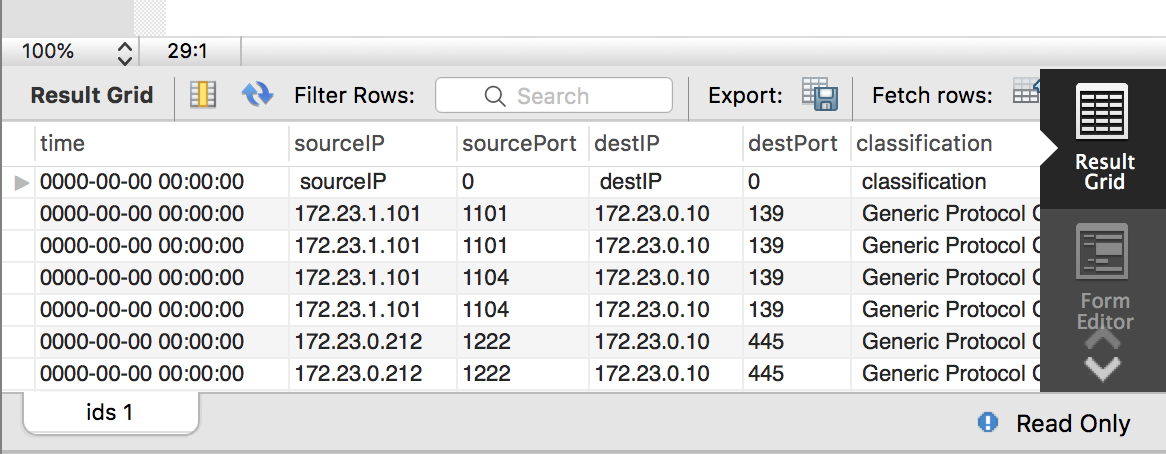

> Indented block



As you can see, there are some issues with the Timestamp column, as in all of the entries are 0's instead of a date and time. Because we had already spent so much time troubleshooting and debugging to get the this point, and we couldn't find a straightforward way to fix this, we ultimately decided to just load the data locally in R rather than use the database. That way we could move on with actually analyzing the data. However, we feel as though we learned a lot in this process about creating a cloud database, and we are proud of ourselves for getting to this point!

## Analysis

In [ ]:
# read in data
firewall1 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-part1.txt", col_names = FALSE)
firewall2 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-part2.txt")
firewall3 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-part3.txt", col_names = FALSE)
firewall4 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-part4.txt")
firewall_day1 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-04062012.csv")
firewall_day2 <- vroom::vroom("~/Downloads/dc4-data/Firewall/Firewall-04072012.csv")
ids_day1 <- vroom::vroom("~/Downloads/dc4-data/IDS/IDS-0406.csv")
ids_day2 <- vroom::vroom("~/Downloads/dc4-data/IDS/IDS-0407.csv")

### What security trends do you notice in the firewall and IDS logs over the course of the two days?


After spending hours on troubleshooting with database management, we decided to just load the files into R locally.  When doing so, we found some interesting connections between IP addressed in the April 6th and 7th firewall files. 

Specifically on day 1, we found the IP address with the most outgoing communication.  It turns out that source IP 172.23.0.132 had a high magnitude of outgoing communication in comparison to other source IP addresses.

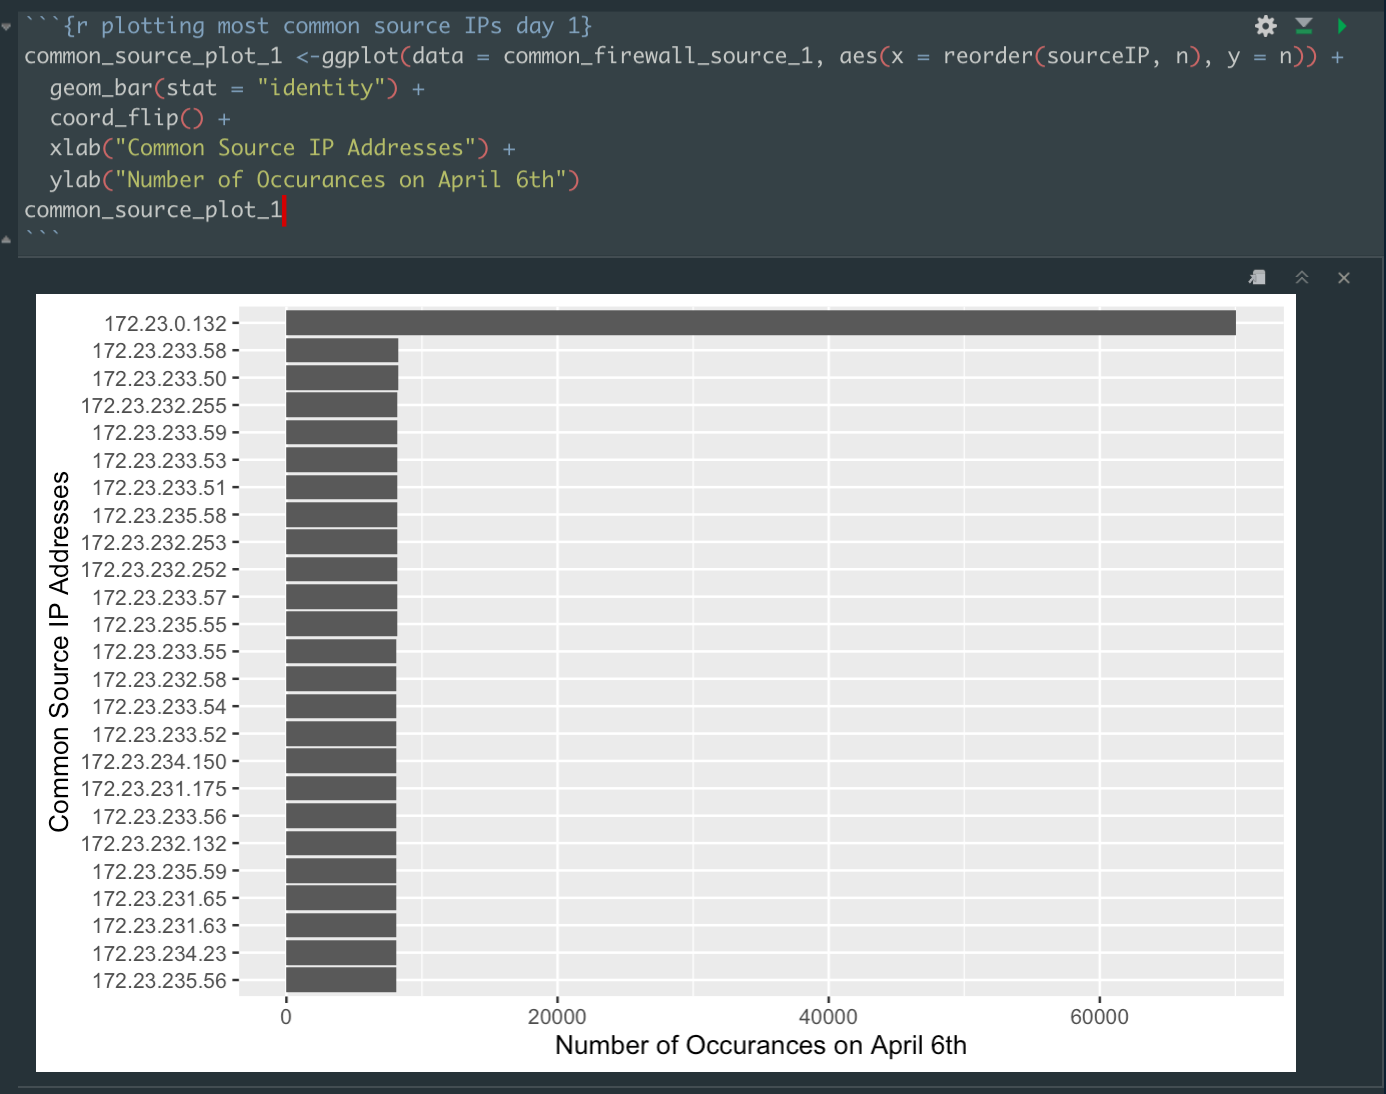

After discovering this, we wanted to see exactly who (or which IP addresses) source IP 172.23.0.132 was communicating with most frequently.  In searching for the answer to this inquiry, we found that source IP most frequently communicated with destination IP 10.32.0.100 on April 6th, as well as a few other destination IP addresses. 

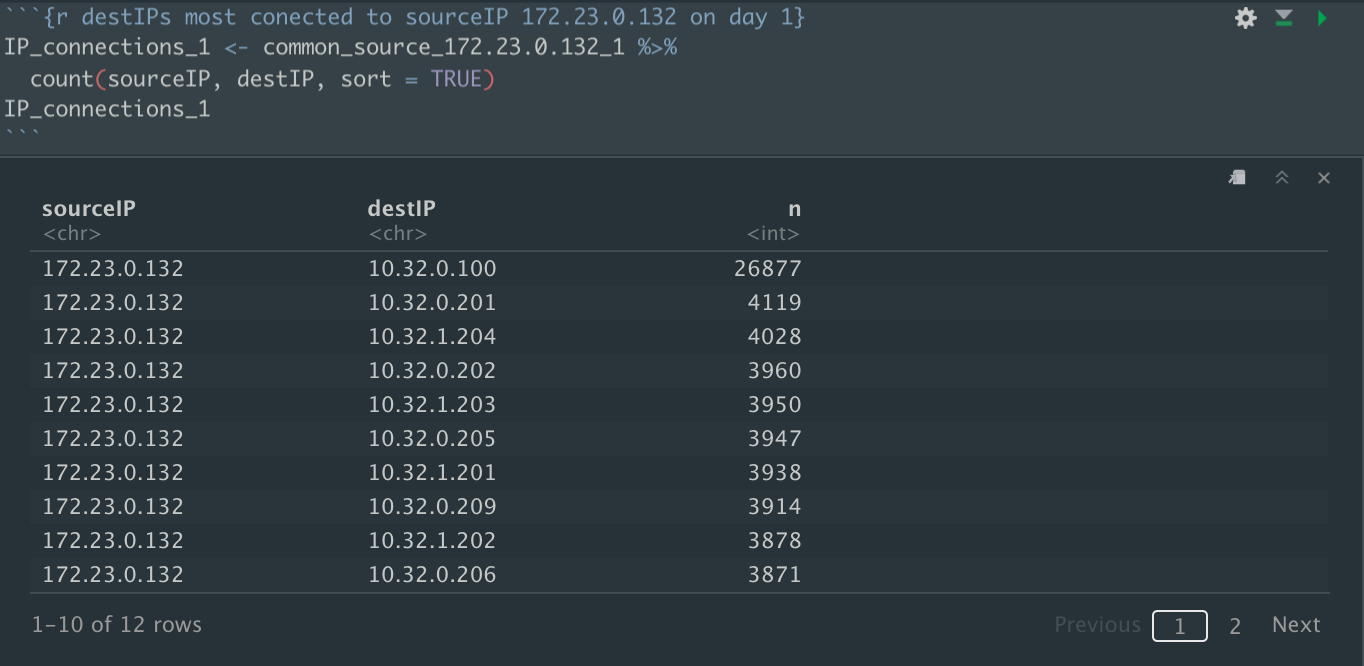

We also were interested in visualizing these connections.  We thought a network graph would be the best way to do this.  This network graph had weighted edges, meaning that the darker the edge, the more frequent the communication between the two IP addresses.  

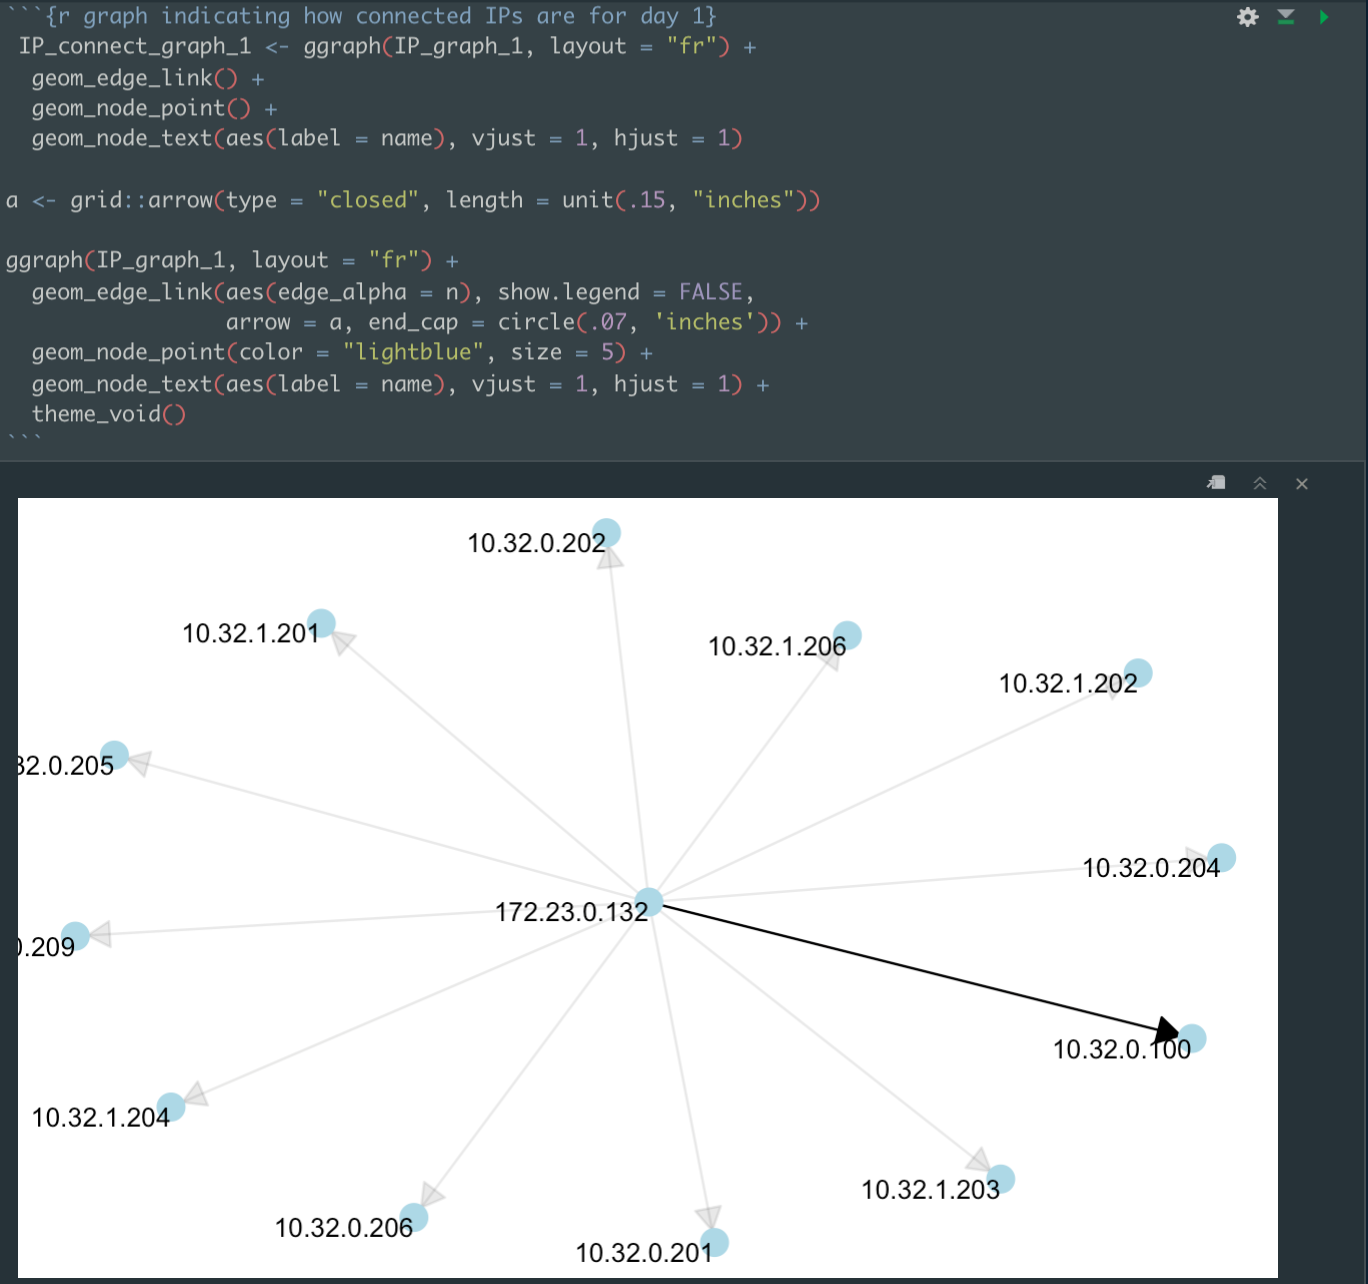

We followed a similar process for analyzing firewall data on April 7th.  First, we found the most common source IP (in the case of the April 7th firewall data it was 172.23.252.10).  Next we found the destination IP addresses that source IP 172.23.252.10 communicated with.  Then we graphed the network to visualize the connections between source IP 172.23.252.10 and the corresponding frequent destination IPs.  

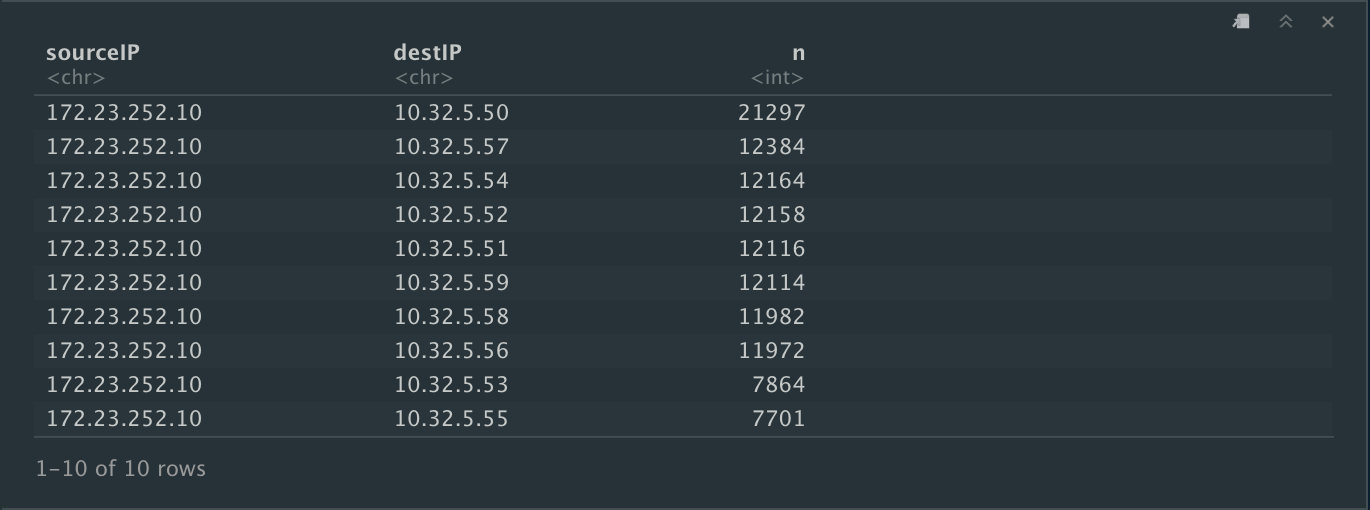

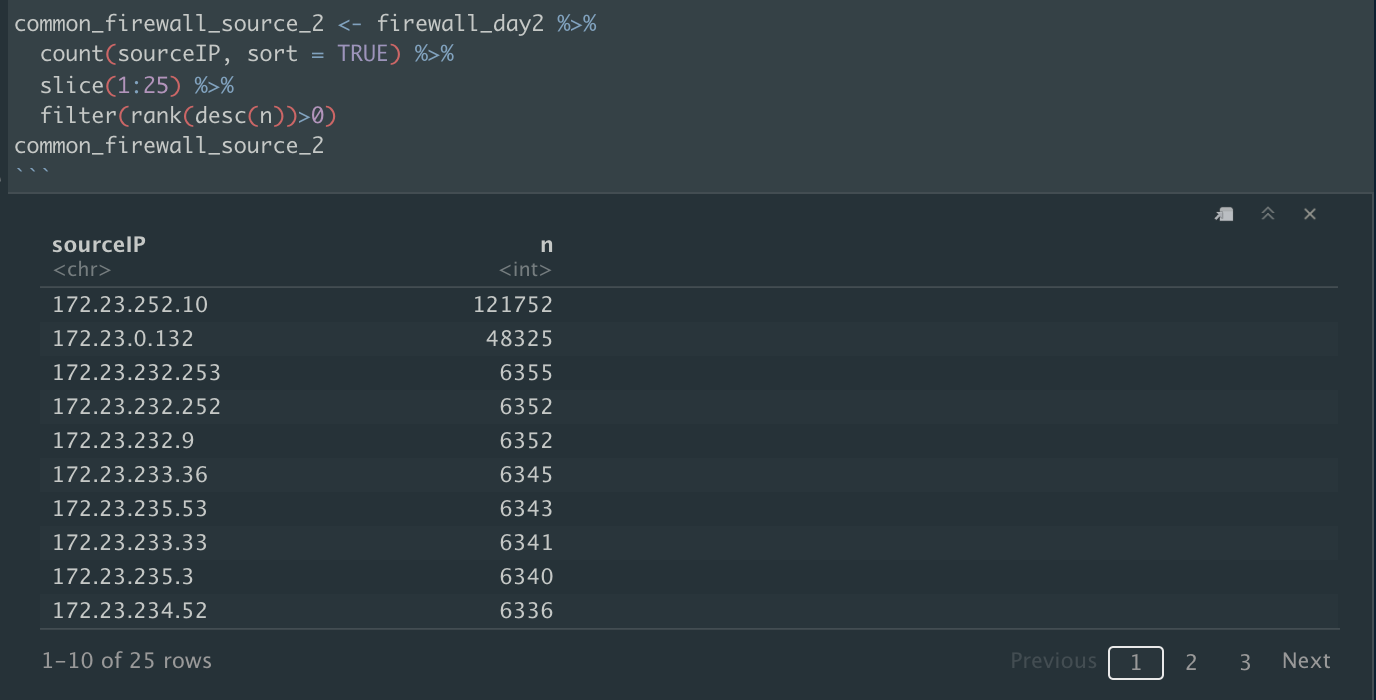

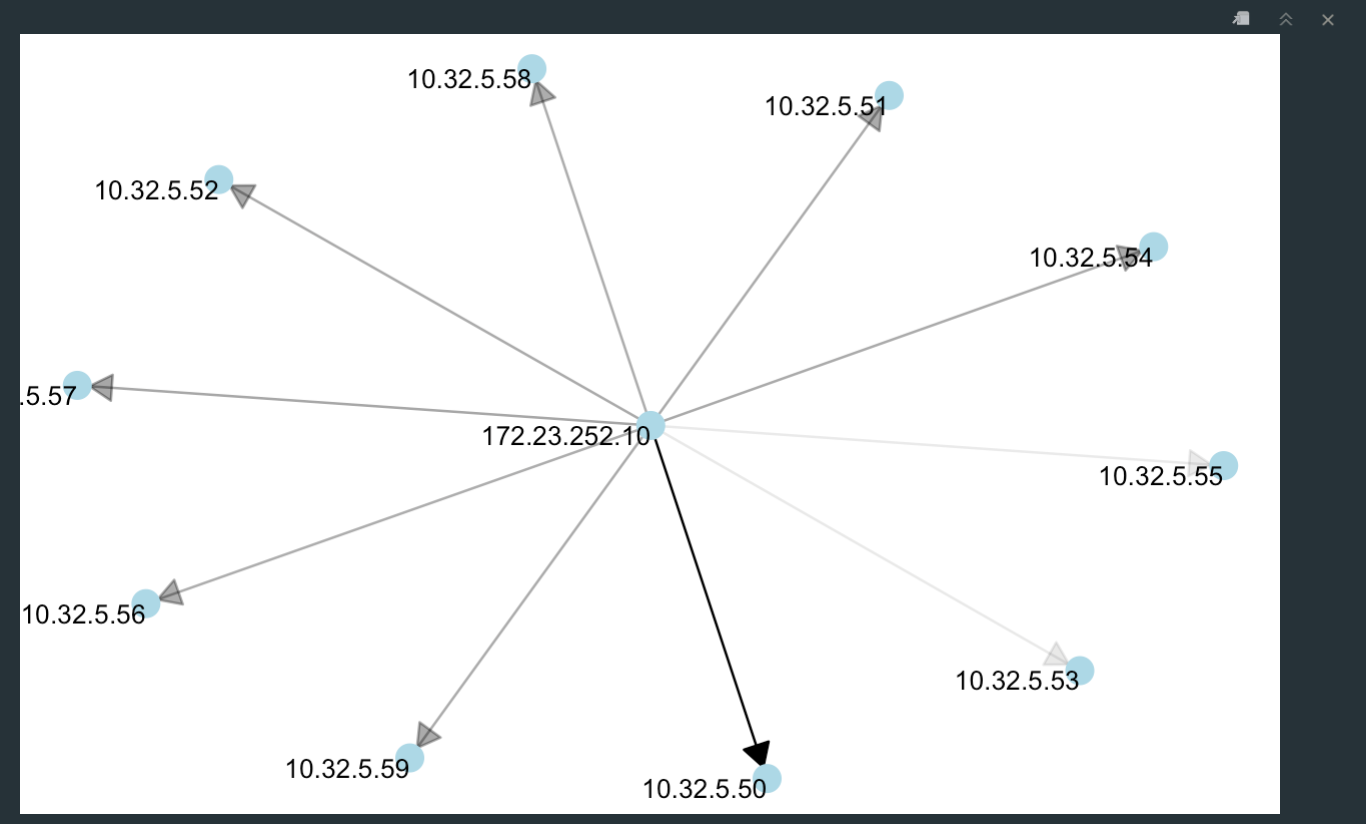

In identifying the trends, we found out that the source IP 172.23.0.132 is a workstation of an employee and the two destination IP’s 10.32.5.50 and 10.32.0.100 are websites accessible by bank employees. 

This is intriguing so we compared to the the Intrusion Detection System (IDS) logs. Surprisingly, nothing pops for for the employee workstation with IP 172.23.0.132. We think that this high amount of connections and no log in the IDS indicates something is wrong. 

A hypothesis may be that this workstation is actually is going undetected and has caused the ad-ware to spread through the employee workstations. 

### What noteworthy events took place for the time period covered in the firewall and IDS logs?


In the IDS, we summarised the connections made between the source ports and the destination ports using grouping. We found out the the destination port 445 appears a lot in the top 10 as shown in the table below. 

In [ ]:
# change time into datetime type
ids_day1$time <- parse_date_time(ids_day1$time, "%m/%d/%Y %H:%M")
ids_day2$time <- parse_date_time(ids_day2$time, "%m/%d/%Y %H:%M")

# bind datasets together
ids <- rbind(ids_day1,ids_day2)
ids %>% group_by(sourcePort, destPort) %>% summarise(n = n()) %>% arrange(desc(n))

ids %>% group_by(destPort, sourcePort) %>% summarise(n = n()) %>% arrange(desc(n))

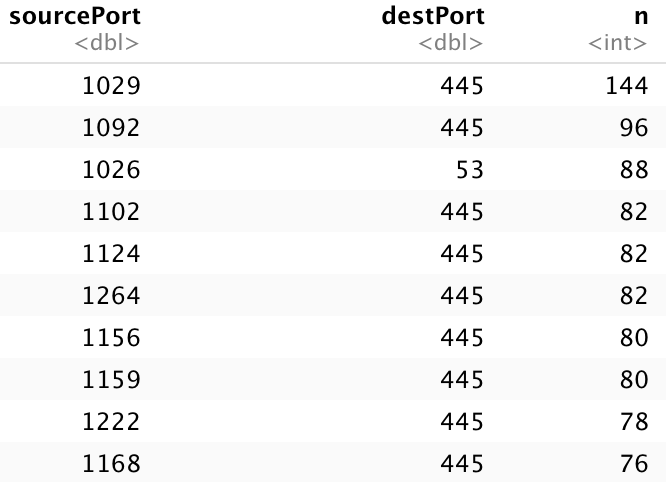

To figure our whether this was related to an information leak, we ran the following code and it turns out that there actually aren't any connections from destination port 445 which have an attempted information leak. 

In [ ]:
ids %>%
  filter(destPort == 445) %>%
  filter(classification == "Attempted Information Leak") 

This is is noteworthy becuase we wonder what is happening at port 445? Port 445, from the [List of Ports](https://en.wikipedia.org/wiki/List_of_TCP_and_UDP_port_numbers) linked in the Network Description File is classified as a "Directory Services" port.

We are suspicious that the directory services, which has the information about the other workstations, is spreading the ad-ware in the Bank of Money Network.

Additionally, we noticed that one of the possible categories in the "classification" column of the IDS logs was "Potential Corporate Privacy Violation." We thought these connections might have contributed to the network vulnerability, so we filtered the IDS logs for April 5th to include all observations classified as a potential privacy violation.

For day one of the IDS logs (April 5th), there are 60 instances classified as potential corporate privacy violations. For all 60 of these violations, the destination IP is 172.23.0.10, which according to the description doc is "the server running critical network operations: domain controller and domain name server." Moreover, all of these potential violations occur at 18:07 (6:07 PM) on April 5th. We also looked at the source IPs for all of these connections.

In [ ]:
#look at destination IPs of this classification on day 1 (4/5)
ids_violations %>% 
  group_by(destIP) %>% 
  count(destIP)

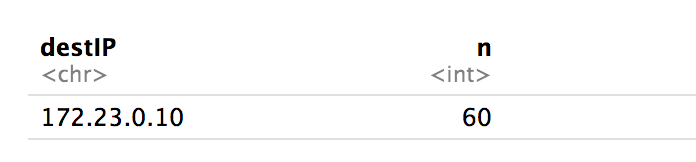

In [ ]:
#look at source IPs for this classification on day 1
ids_violations %>% 
  group_by(sourceIP) %>% 
  count(destIP)

ids_graph_1 <- ids_violations %>% 
  group_by(sourceIP) %>% 
  count(destIP) %>% 
  graph_from_data_frame()

#create network graph for source ips of potential corporate privacy violations
ids_connect_graph_1 <- ggraph(ids_graph_1, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(ids_graph_1, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "hot pink", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

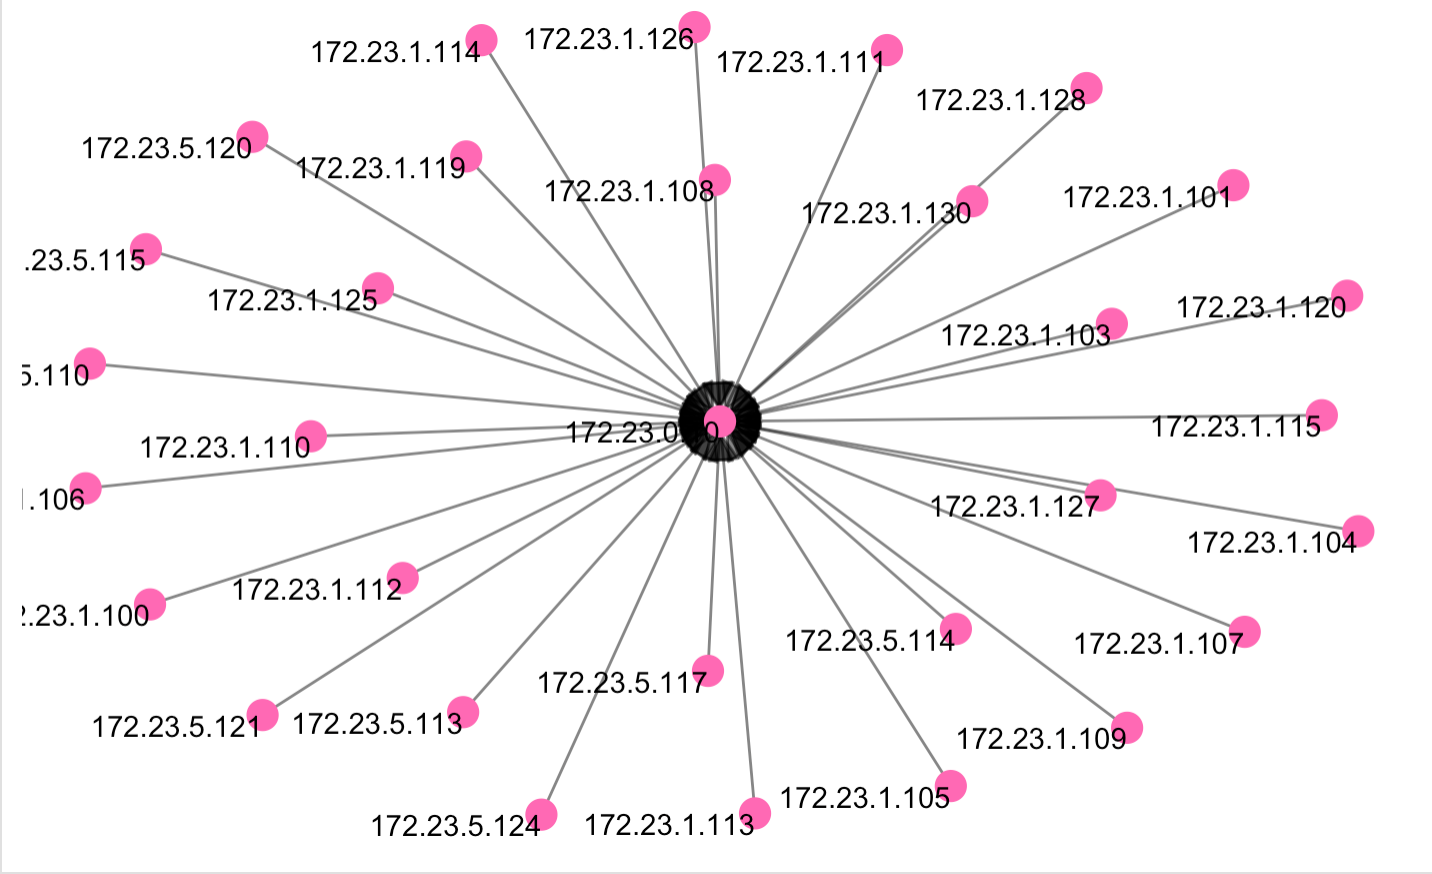

There were 30 different source IPs that made a potential corporate privacy violation at 6:07 PM on April 5th. They are all of the form 172.25.x.x, which according to the data description are individual computers located in offices or cubicles throughout Bank of Money. There were two connections between each of these source IPs and the destination IP. Additionally, all of these source IPs except two have the same port, 1026. 172.23.1.128 and 172.23.1.120 have port 1027.

Next we repeated the same process for the IDS logs from April 6th. 

In [ ]:
#repeating the same process for day 2 of IDS data
ids_violations_2 <- ids_day2 %>% 
  filter(classification == "Potential Corporate Privacy Violation")

ids_violations_2 %>% 
  group_by(destIP) %>% 
  count(destIP)

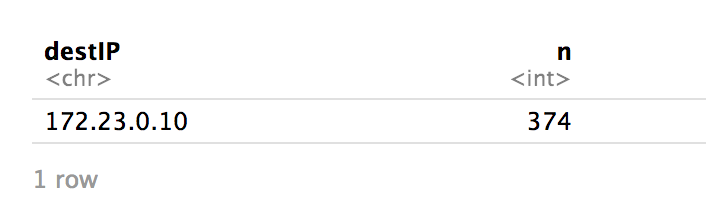

Again, all violations have the same destination IP as day 1, but this time there are 374 potential violations instead of only 60. They occur between 17:26 (5:26 PM) and 18:17 (6:17 PM) on April 6th.

In [ ]:
#look at source IPs for this classification on day 1
ids_violations_2 %>% 
  group_by(sourceIP) %>% 
  count(destIP)

ids_graph_2 <- ids_violations_2 %>% 
  group_by(sourceIP) %>% 
  count(destIP) %>% 
  filter(n > 5) %>% 
  graph_from_data_frame()

#create network graph for source ips of potential corporate privacy violations
ids_connect_graph_2 <- ggraph(ids_graph_2, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)

a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(ids_graph_2, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "hot pink", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

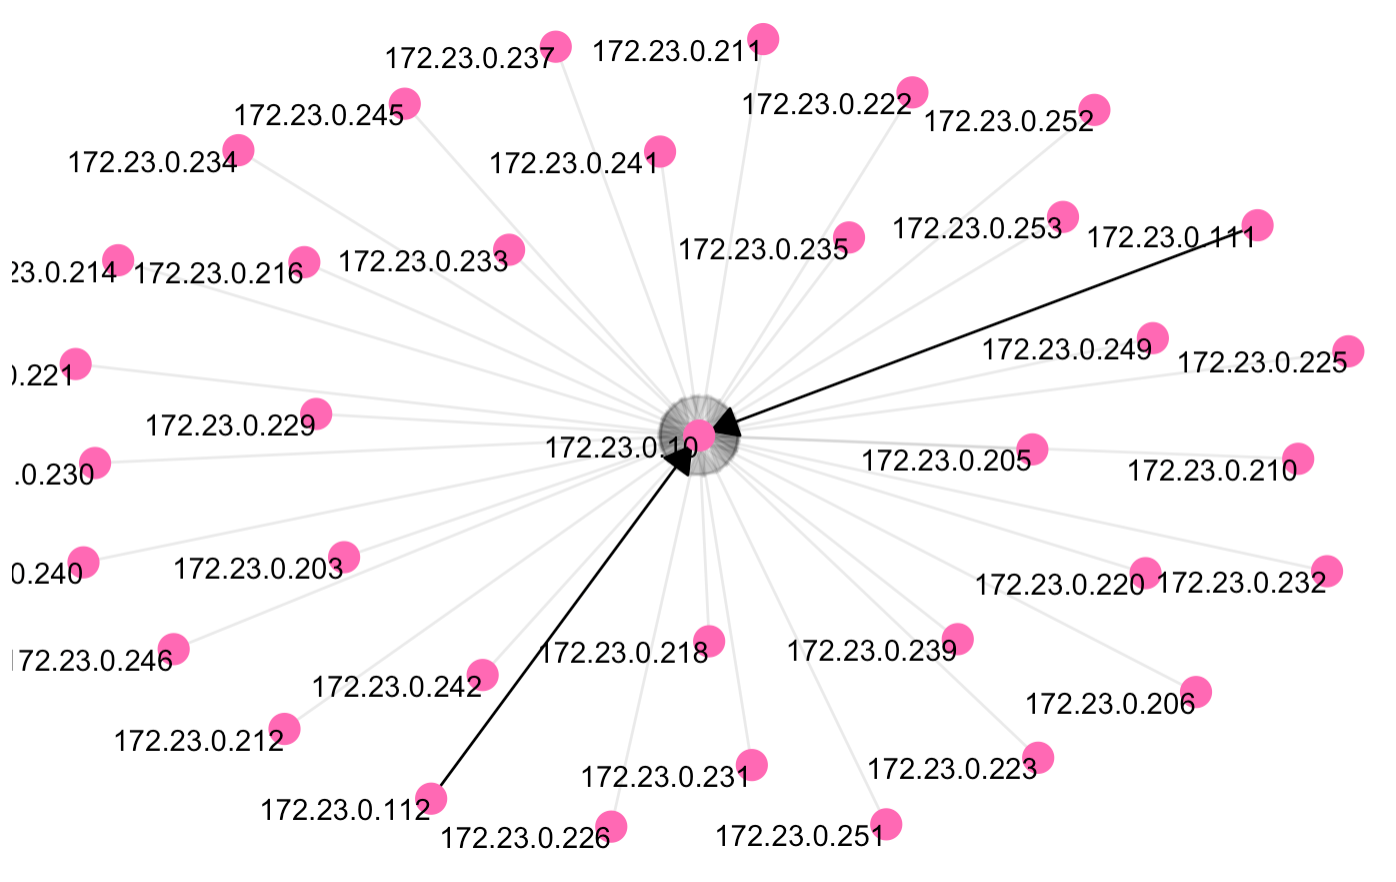

There are two source IPs that have 12 connections, while all others have either 6, 4, or 2. To simplify the network, we filtered the source ips that had 6 or more connections. All of these source IPs also appear to be individual office computers. The IPs with the most connections to the destination IP were 172.23.0.111 and 172.23.0.112.

Something clearly happened on the evenings of the 5th and 6th with the connection to IP 172.23.0.10 that caused these potential privacy violations, and they were all from individual office computers. Perhaps there is actually a virus on these computers that is compromising the Bank of Money's privacy, and that is why all of them happened in a set timeframe. (It is especially strange that on April 5th they all happened at the same time down to the minute.) Additionally, the fact that IP 172.23.0.10 is the domain controller feels significant.

### What do you suspect are the root causes of the events you identified?

The **root** causes in our opinion for the events we identified is some sort of virus take-over that could be a source of a breach that slowly started affecting more amd more company computers. There were potential privacy violations that took some connections down, and if we had more time, we would have looked at more of the inconsistencies. It looks like despite realizing that there might be a network infection, the computers are not healed within the two days. Different IP addresses disappear at random parts of the day and then re-appear, which could be a result of the virus spreading and causing gaps in connection. A potential issue is that the data centers were initially affected, and then any computer that establishes a connection, gets infected. 

### Understanding that you cannot shut down the corporate network or disconnect it from the internet, what actions should the network administrators take to mitigate these root issues?

We understand that we cannot shut down the corporate network or disconnect from the internet, but if we can clean the company computers that have been affected by the virus so far, then we can stop the spread through file sharing. We could remove any malicious traces, from an app or files, and clear cache. Moving forward, there should be an increase in scanning for such virus before a download and before opening files. This can be done through antivirus set-ups.

In regards to networks, if there is a firewall warning early on, then we can slow down, and stop the spread faster by handling an issue earlier on.

## Conclusion

We have learned quite a few things during this data challenge and we will list them below:

* How to set up and connect databases
* How to connect to the cloud
* Computer Network terminology
* Trouble shooting
* Using resources effectively
* Pivoting when necessary

Ultimately, in regards to the challenge, we realize there is some virus spreading between the networks, and it should be traced and removed.